In [1]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### Leitura do arquivo

No Firebase os dados encontram-se ordenados como estruturas aninhadas. Vamos usar a função Export JSON no Firebase console.

<img src=firebase_object_tree.png width=200>


A função *Exportar o JSON* fica à direita na visão de base de dados:
<img src=export_json.png width=500>

In [2]:
arquivo = open("categoriacd-export.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

### Análise do atributo logs

 Veja que log, que contém todos os dados, está pesadamente aninhado

In [3]:
for k,v in dados_fire["logs"].items():
    # print(k,v) # habilite para imprimir as chaves de mais alto nível
    for chave, valor in v.items():
        # print(chave, valor) # habilite para imprimir as chaves inferiores
        pass # desabilite quando reabilitar a linha de cima



### Convertendo para um dataframe

O pandas entende listas de dicionários que têm as mesmas chaves. O Firebase nos dá dicionários de dicionários de dicionários. 

Vamos precisar converter. Basta inserir todos os itens que estavam na chave "logs" em uma lista

In [4]:
lista_dicionarios = []

for k,v in dados_fire["logs"].items():
    lista_dicionarios.append(v)

        


A função `from_records` converte a lista de dicionários em um dataframe

In [5]:
dataframe = pd.DataFrame.from_records(lista_dicionarios)

Desta forma temos o dataframe. Observe que os eventos são dos seguintes tipos:

* *inicio* - quando um usuário inicia uma tarefa
* final - quando o usuário termina uma tarefa

Precisamos agrupar pelo `id` do usuário e depois subtrair o tempo inicial do final, para sabermos quanto tempo efetivamente levou aquela tarefa

In [6]:
dataframe

,tempo,tipo,user_id,versao
0,1479376899428,final,1546574286,A
1,1479345591168,inicio,978031372,B
2,1479379689669,inicio,1513840307,A
3,1479346950676,inicio,2766741010,A
4,1479343949927,inicio,853823534,A
5,1479344046023,inicio,3774183163,B
6,1479344978785,final,779790251,A
7,1478285005997,final,542355478,B
8,1479344700849,inicio,326681286,B
9,1478309349465,final,1062457176,A


### Convertendo para um DataFrame de delta_t

In [7]:
agrupado = dataframe.groupby(by=["user_id", "versao"])

In [8]:
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once

In [9]:
users = list(users) 

In [10]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})

In [11]:
grupo1.sort_values(by="tempo")

,tempo,tipo,user_id,versao
100,1479343984407,inicio,3774183163,B
5,1479344046023,inicio,3774183163,B
122,1479344122766,final,3774183163,B


In [12]:
dataframe_resumo = pd.DataFrame.from_records(resultados)

In [13]:
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos

In [14]:
dataframe_resumo

,delta_t,user_id,versao
0,20.348,3857193483,B
1,20.368,1686436492,B
2,127.473,2766741010,A
3,28.412,542355478,B
4,37.600,3936828694,A
5,50.978,2244328473,B
6,26.169,2991394204,A
7,16.863,1431168288,A
8,9.945,3729058087,A
9,21.337,779790251,A


# Comparação dos histogramas

(array([  1.,   0.,   0.,   0.,   0.,   0.,   5.,  11.,   0.,   2.]),
 array([-253.291, -214.126, -174.961, -135.796,  -96.631,  -57.466,
         -18.301,   20.864,   60.029,   99.194,  138.359]),
 <a list of 10 Patch objects>)

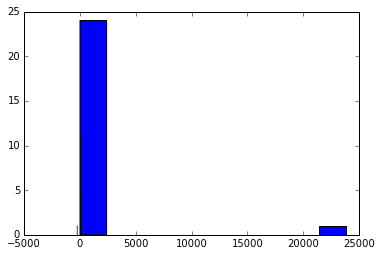

In [15]:
tempos_A = list(dataframe_resumo[dataframe_resumo.versao=="A"].delta_t)
tempos_B = list(dataframe_resumo[dataframe_resumo.versao=="B"].delta_t)
plt.hist(tempos_A, bins=10)
plt.hist(tempos_B, bins=10, alpha=0.5)

In [24]:
#filtrando resultados aberrantes
for i in tempos_A:
    if i < 0:
        tempos_A.remove(i)
    if i > 300:
        tempos_A.remove(i)
        
for i in tempos_B:
    if i < 0:
        tempos_B.remove(i)
    if i > 300:
        tempos_B.remove(i)
        
print(tempos_A)
print(tempos_B)

[127.473, 37.600000000000001, 26.169, 16.863, 9.9450000000000003, 21.337, 86.725999999999999, 92.408000000000001, 41.243000000000002, 286.00700000000001, 45.226999999999997, 17.120000000000001, 14.007999999999999, 14.077999999999999, 15.725, 6.2610000000000001, 26.077000000000002, 25.898, 13.06, 16.881, 31.715]
[20.347999999999999, 20.367999999999999, 28.411999999999999, 50.978000000000002, 31.145, 21.224, 20.306999999999999, 53.581000000000003, 28.876000000000001, 10.58, 47.683999999999997, 37.542999999999999, 47.494, 108.46299999999999, 53.802, 33.061999999999998, 12.895, 138.35900000000001]


In [23]:
#calculando media, desvio padrao e variancia de A
somaA = 0
for i in tempos_A:
    somaA += i
mediaA = somaA / len(tempos_A)

somaA = 0
for i in tempos_A:
    somaA += (i - mediaA) ** 2
desvioA = somaA / len(tempos_A)

varA = desvioA ** 2

print("A media é :{0}".format(mediaA))
print("O desvio é :{0}".format(desvioA))
print("A variância é :{0}".format(varA))

A media é :1126.9356363636364
O desvio é :24527894.687748313
A variância é :601617617813271.9


In [20]:
#calculando media, desvio padrao e variancia de B
somaB = 0
for i in tempos_B:
    somaB += i
mediaB = somaB / len(tempos_B)

somaB = 0
for i in tempos_B:
    somaB += (i - mediaB) ** 2
desvioB = somaB / len(tempos_B)

varB = desvioB ** 2